# LSTM Classifier for Vehicle Collision Prediction

## Notebook Setup
import python libraries, set path and default options, define feature set to use for model, define hyperparameters

In [ ]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from itertools import product
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# set the home directory using absolute path
os.chdir('c:/Users/01eco/Documents/Programming/Python/multisource_ML_research')
pd.set_option("future.no_silent_downcasting", True)
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
# set random generation seed for torch
random_state = 42
torch.manual_seed(random_state)

In [2]:
# define parameters of the lstm model and training measures
window_length = 20
batch_size = 32 # number of windows given to model to train before updating parameters

# Define train/validation split balance
train_balance = 0.8
validation_balance = 1 - train_balance

In [59]:
# define the features to be used to train the lstm model as a list of both vehicle features and eye tracking features
vehicle_features = [
    'Speed/X_t0',
    'Speed/Y_t0',
    'Brake pedal force_t0',
    'Gas pedal_t0',
    'Steering wheel angle_t0'
]

eye_tracking_features = [
    'Data Gaze2D X_t0',
    'Data Gaze2D Y_t0',
    'Velocity_t0',
    'Is_Fixation_t0',
    'Is_Gaze_On_Hazard_t0',
    'Avg_Pupildiameter_t0'
]

all_features = vehicle_features + eye_tracking_features
print(all_features)

# get the number of total features
total_features = len(all_features)
print(total_features)

['Speed/X_t0', 'Speed/Y_t0', 'Brake pedal force_t0', 'Gas pedal_t0', 'Steering wheel angle_t0', 'Data Gaze2D X_t0', 'Data Gaze2D Y_t0', 'Velocity_t0', 'Is_Fixation_t0', 'Is_Gaze_On_Hazard_t0', 'Avg_Pupildiameter_t0']
11


## Import Dataset
Read encounters into the dataset one at a time
For each, clean boolean features, remove rows with N/A values, and ensure data exists
Pull selected features from the encounter
For each record, apply windowing technqiue to collect a sequence of rows (defined by window_length parameter) and save to array
Also pull target value from encounter since it is the same for all records in the encounter

In [80]:
windows = []
targets = []

analysis_data = []
encounters = 0

In [81]:
# define the root folder for the data
data_root = 'data/processed_data/binned_data_1'
bins = os.listdir(data_root)
# iterate through all the bins in the root folder
for b in bins:
    files = os.listdir(f'{data_root}/{b}')
    # iterate through each encounter in the current bin
    for f in files:
        file_path = f'{data_root}/{b}/{f}'
        # open the encounter data into a pandas df
        encounter_df = pd.read_csv(file_path)
        
        # clean the file for True and False values to set them as 1 or 0
        encounter_df = encounter_df.replace({False: 0, True: 1,'False': 0, 'True': 1,'0.0': 0,'1.0': 1})
        # remove rows with N/A values
        encounter_df.dropna(inplace=True)
        # set the collision_flag to the global_collision_flag
        collision_flag = encounter_df['global_collision_flag_t0']

        # there are at least one or two encounters with no data so check for this condition before proceeding
        if encounter_df.shape[0] != 0:
            # collect the data from the encounter based on the selected features
            vehicle_data = encounter_df[vehicle_features]
            eye_data = encounter_df[eye_tracking_features]

            # combine vehicle and eye data without scaling
            features = np.hstack([vehicle_data, eye_data])

            # iterate through encounter_df length
            # apply sliding window technique using window_length parameter
            # range max adjusts encounter length to not pull windows that exceed encounter length
            for w in range(len(encounter_df) - window_length + 1):
                # append a subset of data of length window_length to windows from the feature set and targets from the target set
                windows.append(features[w:(w + window_length)])
                targets.append(int(collision_flag.iloc[w + window_length - 1]))

                analysis_record = np.insert(np.append(features[w],int(collision_flag.iloc[w + window_length - 1])),0,encounters)
                analysis_data.append(analysis_record)
            
            encounters+=1

# convert windows and targets to numpy arrays
windows_array = np.array(windows)
target_array = np.array(targets)

analysis_df = pd.DataFrame(analysis_data)
analysis_df.columns = (['encounter_num'] + all_features + ['target'])

## Data Analysis

In [87]:
analysis_df.describe()

,encounter_num,Speed/X_t0,Speed/Y_t0,Brake pedal force_t0,Gas pedal_t0,Steering wheel angle_t0,Data Gaze2D X_t0,Data Gaze2D Y_t0,Velocity_t0,Is_Fixation_t0,Is_Gaze_On_Hazard_t0,Avg_Pupildiameter_t0,target
count,309594.000000,309594.000000,309594.000000,309594.000000,309594.000000,3.095940e+05,309594.000000,309594.000000,3.095940e+05,309594.000000,309594.000000,309594.000000,309594.00000
mean,139.464831,-233.474065,12.857100,-13.744699,42.619744,-4.345727e+05,0.577850,-0.262665,5.144521e+09,0.706403,0.039516,4.688011,0.02898
std,80.211951,2570.247543,242.808054,389.506233,643.522763,8.018840e+06,6.801251,47.433999,4.963937e+11,0.455410,0.194820,12.567641,0.16775
min,0.000000,-56906.725916,-939.795638,-15193.402235,-5055.265696,-2.965329e+08,-71.041492,-5265.453767,-1.973249e+11,0.000000,0.000000,-53.218408,0.00000
25%,71.000000,7.553875,-0.025032,0.000000,0.154605,-4.474173e+00,0.459680,0.435262,2.372348e+00,0.000000,0.000000,3.976935,0.00000
50%,138.000000,24.266400,-0.001857,0.000000,0.503457,-4.500000e-01,0.491614,0.503956,9.191016e+00,1.000000,0.000000,4.444138,0.00000
75%,209.000000,60.763084,0.008319,0.000000,0.717897,1.674000e+00,0.526507,0.577221,3.854553e+01,1.000000,0.000000,4.922808,0.00000
max,278.000000,13013.239929,8487.753051,4400.967271,19547.552806,1.834226e+06,743.295506,11.131350,8.624261e+13,1.000000,1.000000,1438.751478,1.00000


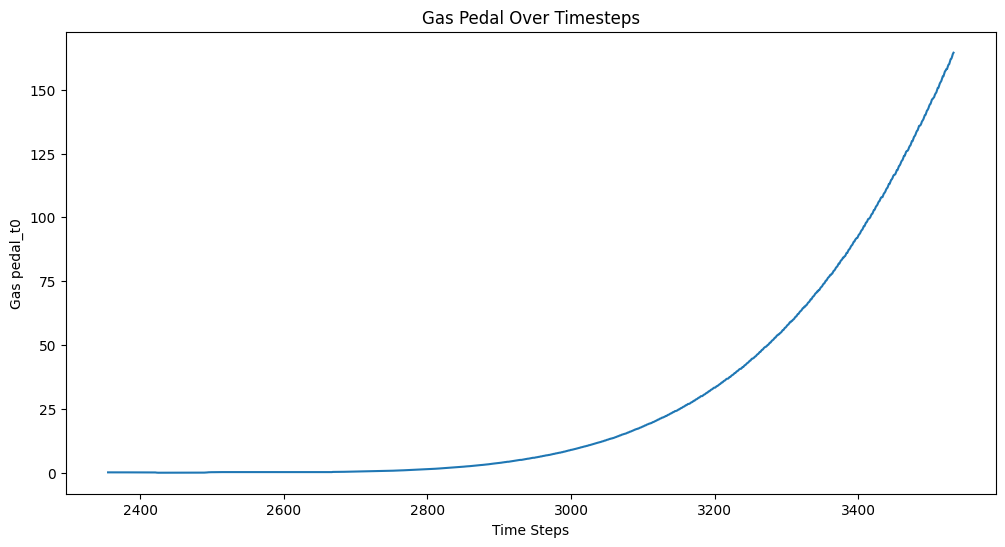

In [135]:
encounter_num = 2
current_feature = 3

plt.figure(figsize=(12, 6))
sns.lineplot(data=analysis_df[analysis_df['encounter_num'] == encounter_num], x=analysis_df[analysis_df['encounter_num'] == encounter_num].index, y=all_features[current_feature])
plt.xlabel('Time Steps')
plt.ylabel(all_features[current_feature])
plt.title(f'Gas Pedal Over Timesteps')
plt.show()

## Data Preparation

### Plot Class Balance of Dataset

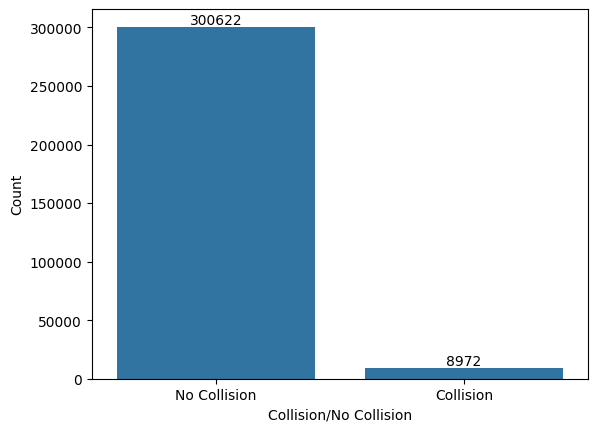

In [6]:
# plot the class balance in the targets array
ax = sns.countplot(x=target_array)
ax.bar_label(ax.containers[0])
plt.xlabel('Collision/No Collision')
plt.ylabel('Count')

plt.xticks([0,1],['No Collision','Collision'])
plt.show()

In [7]:
# attempt to calculate pos_weight based on class balance
unique,counts = np.unique(target_array,return_counts=True)
class_balance = dict(zip(unique,counts))
pos_weight_torch_value = torch.tensor([class_balance[0]/class_balance[1]])

print(int(pos_weight_torch_value))

33


### Split Data Into Training and Validation

In [8]:
# split data into train and validation sets
total_samples = len(windows)
train_size = int(train_balance * total_samples)
validation_size = total_samples - train_size

# randomly shuffle indices of in the total samples range
indices = torch.randperm(total_samples)
# train and validation indices are taken using the sizes from previous
train_indices = indices[:train_size]
validation_indices = indices[train_size:]

# split the data using the indices
train_windows = windows_array[train_indices]
train_targets = target_array[train_indices]
validation_windows = windows_array[validation_indices]
validation_targets = target_array[validation_indices]

print(f'Total Samples = {total_samples}')
print(f'Training Samples = {len(train_targets)}')
print(f'Validation Samples = {len(validation_targets)}')

Total Samples = 309594
Training Samples = 247675
Validation Samples = 61919


#### Plot Class Balance of Training and Validation Sets

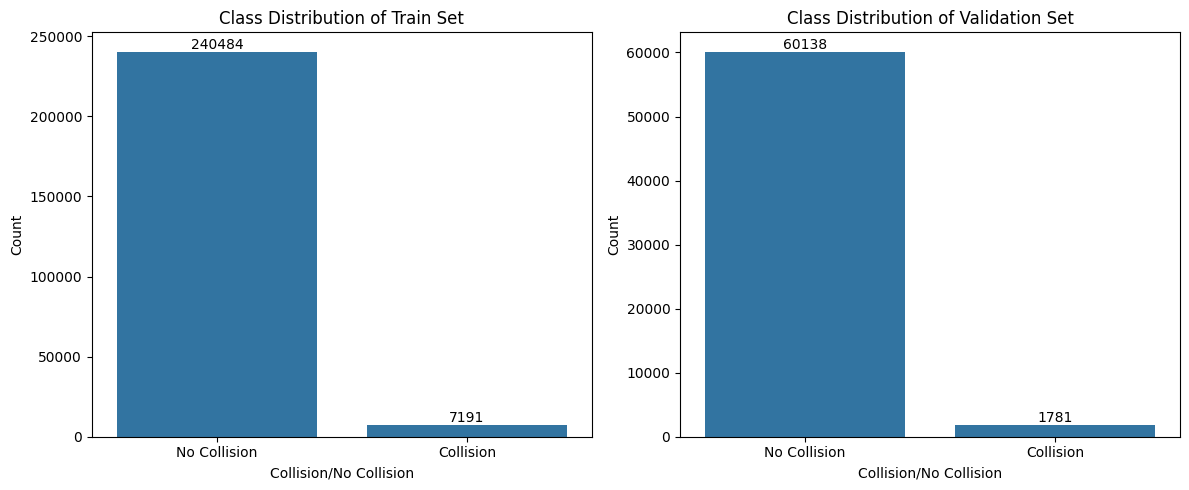

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x=target_array[train_indices], ax=ax1)
ax1.bar_label(ax1.containers[0])
ax1.set_xlabel('Collision/No Collision')
ax1.set_ylabel('Count')
ax1.set_title('Class Distribution of Train Set')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['No Collision','Collision'])

sns.countplot(x=target_array[validation_indices], ax=ax2)
ax2.bar_label(ax2.containers[0])
ax2.set_xlabel('Collision/No Collision')
ax2.set_ylabel('Count')
ax2.set_title('Class Distribution of Validation Set')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['No Collision','Collision'])

plt.tight_layout()
plt.show()

### Scale Dataset Using StandardScaler

In [10]:
# reshape to 2D array (samples,features) for scaling
train_shape = train_windows.shape
validation_shape = validation_windows.shape
train_reshaped = train_windows.reshape(-1, total_features)
validation_reshaped = validation_windows.reshape(-1, total_features)

# create and fit scaler on training data only
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_reshaped)
# transform validation data using the same scaler
validation_scaled = scaler.transform(validation_reshaped)

# reshape back to original shape (samples,window_length,features)
train_windows_scaled = train_scaled.reshape(train_shape)
validation_windows_scaled = validation_scaled.reshape(validation_shape)

# Shape of data = (samples,window_length,features)
print(train_windows_scaled.shape)
print(validation_windows_scaled.shape)

(247675, 20, 11)
(61919, 20, 11)


## Initialize Learning Model

### Convert Training and Validation Data to PyTorch Tensors and Generate DataLoaders

In [11]:
# convert to torch tensors
train_windows_tensor = torch.FloatTensor(train_windows_scaled)
train_targets_tensor = torch.FloatTensor(train_targets)
validation_windows_tensor = torch.FloatTensor(validation_windows_scaled)
validation_targets_tensor = torch.FloatTensor(validation_targets)

#### Move Data to GPU if Available

In [12]:
# use gpu if available, otherwise use the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Construct Learner Class and Training/Evaluation Functions

### Create Learner Class

In [13]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMClassifier, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # define LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate
        )
        
        # define fully connected layers
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)
        
        # get last timestamp output of the lstm layer
        last_timestep = lstm_out[:, -1, :]
        
        # pass through 2 fully connected layers with ReLU activation layer and dropout
        fc1_out = self.fc1(last_timestep)
        relu_out = self.relu(fc1_out)
        dropout_out = self.dropout(relu_out)
        fc2_out = self.fc2(dropout_out)
        
        return fc2_out.view(-1)

#### Create Model Training Function

In [14]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs, device, debug_param_set_num,debug_total_params,debug_status=1):
    metrics_df = pd.DataFrame(columns=['Epoch','Train Loss','Validation Loss','Validation Accuracy','FPR','TPR','ROC-AUC Score'])
    
    for epoch in range(num_epochs):
        # training stage
        model.train()
        train_loss = 0
        
        for batch_windows, batch_targets in train_loader:
            batch_windows = batch_windows.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad() # need to zero out the gradients
            outputs = model(batch_windows) # apply the LSTM model
            loss = criterion(outputs, batch_targets) # measure the loss using the criterion function
            
            loss.backward() # backpropagation
            optimizer.step()
            
            train_loss += loss.item() # update the loss
            
        # validation stage
        model.eval() # set model to evaluation mode
        validation_loss = 0
        correct = 0
        total = 0
        all_probs = []
        all_targets = []
        
        with torch.no_grad(): # do not update gradients
            for batch_windows, batch_targets in validation_loader:
                batch_windows = batch_windows.to(device)
                batch_targets = batch_targets.to(device)
                
                outputs = model(batch_windows) # forward pass through the model
                loss = criterion(outputs, batch_targets) # calculate loss
                validation_loss += loss.item()
                
                # calculate probabilities from the raw logits output 
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).int()
                
                correct += (predicted == batch_targets.int()).sum().item()
                total += batch_targets.numel()
                
                all_probs.extend(probs.cpu().numpy())
                all_targets.extend(batch_targets.cpu().numpy())
        
        # calculate metrics for scoring
        fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
        roc_auc = roc_auc_score(all_targets, all_probs)
        
        optimal_idx = np.argmin(np.abs(thresholds - 0.5))
        fpr_optimal = fpr[optimal_idx]
        tpr_optimal = tpr[optimal_idx]
        
        binary_preds = (np.array(all_probs) > 0.5).astype(int)
        report = classification_report(all_targets, binary_preds, digits=4)
        conf_matrix = confusion_matrix(all_targets, binary_preds)
        
        if debug_status >= 1: # print epoch number
            print(f'-------------- Param set {debug_param_set_num}/{debug_total_params} -- Epoch [{epoch+1}/{num_epochs}] -----------------------')
        if debug_status >= 3: # print full metric list
            print(f'Train Loss: {train_loss/len(train_loader)}')
            print(f'Validation Loss: {validation_loss/len(validation_loader)}')
            print(f'Validation Accuracy: {100 * correct/total}%')
            print(f'Classification Report:\n{report}')
            print(f'False Positive Rate: {fpr_optimal}')
            print(f'True Positive Rate: {tpr_optimal}')
            print(f'ROC-AUC:{roc_auc}')
        if debug_status >= 2: # print epoch number and confusion matrix
            print(f'Confusion Matrix:\n{conf_matrix}')
        
        # concatenate metrics to a dataframe and return it from the function
        metrics_df.loc[len(metrics_df)] = [
            epoch,
            train_loss/len(train_loader),
            validation_loss/len(validation_loader),
            correct/total,
            fpr_optimal,
            tpr_optimal,
            roc_auc
        ]
    
    return metrics_df

In [15]:
def grid_search(param_grid, train_windows_tensor, train_targets_tensor, validation_windows_tensor, validation_targets_tensor, input_size, device, batch_size=32):
    results = []
    
    # generate all combinations of parameters
    param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
    total_combos = len(param_combinations)
    print(f'+++++++++++++++++Beginning Grid Search: {total_combos} parameter combinations+++++++++++++++++++')
    
    # iterate through all combinations of parameters that are passed in param_grid
    for param_set_num,params in enumerate(param_combinations):
        print(f'=========== Testing Conditions {param_set_num}/{total_combos}: {params} =============')
        
        # create model with current parameters and move all components to device specified earlier
        model = LSTMClassifier(
            input_size=input_size,
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            dropout_rate=params['dropout_rate']
        ).to(device)
        
        # create criterion and optimizer
        pos_weight = pos_weight_torch_value.to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        # create data loaders
        train_data = torch.utils.data.TensorDataset(train_windows_tensor, train_targets_tensor)
        validation_data = torch.utils.data.TensorDataset(validation_windows_tensor, validation_targets_tensor)
        
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
        validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=False)
        
        # train model and get metrics
        metrics_df = train_model(
            model=model,
            train_loader=train_loader,
            validation_loader=validation_loader,
            criterion=criterion,
            optimizer=optimizer,
            num_epochs=params['num_epochs'],
            device=device,
            debug_status=1,
            debug_param_set_num=param_set_num,
            debug_total_params=total_combos
        )
        
        # get the best validation metrics based on ROC-AUC score
        best_epoch_metrics = metrics_df.iloc[metrics_df['ROC-AUC Score'].idxmax()]
        
        # store best results to return, alongside training metrics
        results.append({
            'parameters': params,
            'best_roc_auc': best_epoch_metrics['ROC-AUC Score'],
            'best_validation_accuracy': best_epoch_metrics['Validation Accuracy'],
            'best_validation_loss': best_epoch_metrics['Validation Loss'],
            'metrics_df': metrics_df
        })
    
    return results,model

### Run Grid Search on the LSTM Model

#### Define the Hyperparameters

In [16]:
#! parameter grid 1
#* param_grid = {
#     'hidden_size': [64,128,256],
#     'num_layers': [2,3,4],
#     'dropout_rate': [0.05,0.1,0.2,0.3],
#     'learning_rate': [0.01,0.005,0.001,0.0005,0.0001],
#     'num_epochs': [50]
# }

#! parameter grid 1 took 4068m 52.9s (67.9 hours) to run
#* best params follow
# parameter grid 2
param_grid = {
    'hidden_size': [256],
    'num_layers': [3],
    'dropout_rate': [0.3],
    'learning_rate': [0.0001],
    'num_epochs': [500]
}

#### Run Grid Search

In [17]:
grid_result_metrics,grid_result_model = grid_search(
    param_grid=param_grid,
    train_windows_tensor=train_windows_tensor,
    train_targets_tensor=train_targets_tensor,
    validation_windows_tensor=validation_windows_tensor,
    validation_targets_tensor=validation_targets_tensor,
    input_size=total_features,
    device=device
)


+++++++++++++++++Beginning Grid Search: 1 parameter combinations+++++++++++++++++++
=========== Testing Conditions 0/1: {'hidden_size': 256, 'num_layers': 3, 'dropout_rate': 0.3, 'learning_rate': 0.0001, 'num_epochs': 500} =============
-------------- Param set 0/1 -- Epoch [1/500] -----------------------
-------------- Param set 0/1 -- Epoch [2/500] -----------------------
-------------- Param set 0/1 -- Epoch [3/500] -----------------------
-------------- Param set 0/1 -- Epoch [4/500] -----------------------
-------------- Param set 0/1 -- Epoch [5/500] -----------------------
-------------- Param set 0/1 -- Epoch [6/500] -----------------------
-------------- Param set 0/1 -- Epoch [7/500] -----------------------
-------------- Param set 0/1 -- Epoch [8/500] -----------------------
-------------- Param set 0/1 -- Epoch [9/500] -----------------------
-------------- Param set 0/1 -- Epoch [10/500] -----------------------
-------------- Param set 0/1 -- Epoch [11/500] ---------------

In [18]:
# sort grid search results by best_roc_auc score. Can use the following to sort: best_roc_auc, best_validation_accuracy, -best_validation_loss
sorted_grid_results = sorted(grid_result_metrics,key=lambda x: x['best_roc_auc'],reverse=True)

### Analyze the Results of the Best Scoring Parameter Combination

In [19]:
sorted_grid_results[0]['metrics_df']

,Epoch,Train Loss,Validation Loss,Validation Accuracy,FPR,TPR,ROC-AUC Score
0,0.0,1.238587,1.149568,0.455628,0.558765,0.925323,0.743190
1,1.0,1.157899,1.134562,0.694714,0.303036,0.620999,0.749673
2,2.0,1.125581,1.134442,0.687220,0.311051,0.629422,0.759752
3,3.0,1.125357,1.060958,0.673557,0.329625,0.766985,0.779441
4,4.0,1.097956,1.055771,0.588010,0.420516,0.879843,0.788990
5,5.0,1.088788,1.028129,0.610846,0.397436,0.877035,0.805155
6,6.0,1.072751,1.034621,0.639061,0.366889,0.836047,0.798116
7,7.0,1.062730,1.207785,0.556776,0.447936,0.715890,0.675320
8,8.0,1.043700,0.994453,0.659733,0.345871,0.848961,0.806404
9,9.0,1.016655,0.971256,0.694391,0.309821,0.831555,0.825408


### Display Metrics and Final Results

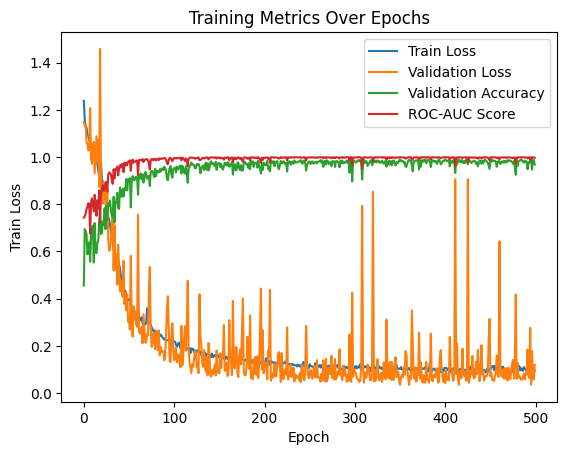

In [20]:
sns.lineplot(data=sorted_grid_results[0]['metrics_df'], x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=sorted_grid_results[0]['metrics_df'], x='Epoch', y='Validation Loss', label='Validation Loss')
sns.lineplot(data=sorted_grid_results[0]['metrics_df'], x='Epoch', y='Validation Accuracy', label='Validation Accuracy')
sns.lineplot(data=sorted_grid_results[0]['metrics_df'], x='Epoch', y='ROC-AUC Score', label='ROC-AUC Score')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.show()

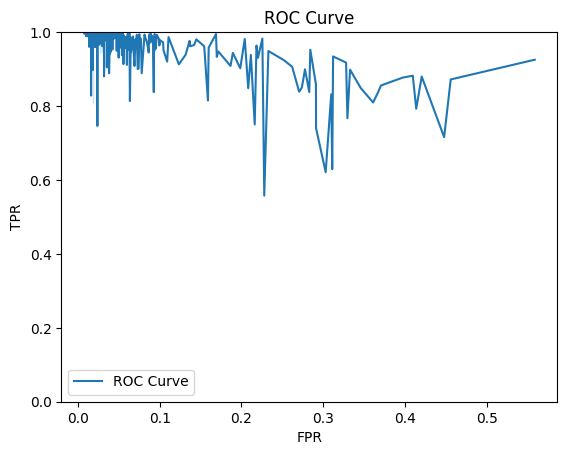

In [21]:
sns.lineplot(data=sorted_grid_results[0]['metrics_df'], x='FPR', y='TPR', label='ROC Curve')
plt.title('ROC Curve')
plt.ylim(0, 1)
plt.legend()
plt.show()

In [22]:
sorted_grid_results[0]['metrics_df'].head(50)

,Epoch,Train Loss,Validation Loss,Validation Accuracy,FPR,TPR,ROC-AUC Score
0,0.0,1.238587,1.149568,0.455628,0.558765,0.925323,0.743190
1,1.0,1.157899,1.134562,0.694714,0.303036,0.620999,0.749673
2,2.0,1.125581,1.134442,0.687220,0.311051,0.629422,0.759752
3,3.0,1.125357,1.060958,0.673557,0.329625,0.766985,0.779441
4,4.0,1.097956,1.055771,0.588010,0.420516,0.879843,0.788990
5,5.0,1.088788,1.028129,0.610846,0.397436,0.877035,0.805155
6,6.0,1.072751,1.034621,0.639061,0.366889,0.836047,0.798116
7,7.0,1.062730,1.207785,0.556776,0.447936,0.715890,0.675320
8,8.0,1.043700,0.994453,0.659733,0.345871,0.848961,0.806404
9,9.0,1.016655,0.971256,0.694391,0.309821,0.831555,0.825408


c:\Users\01eco\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


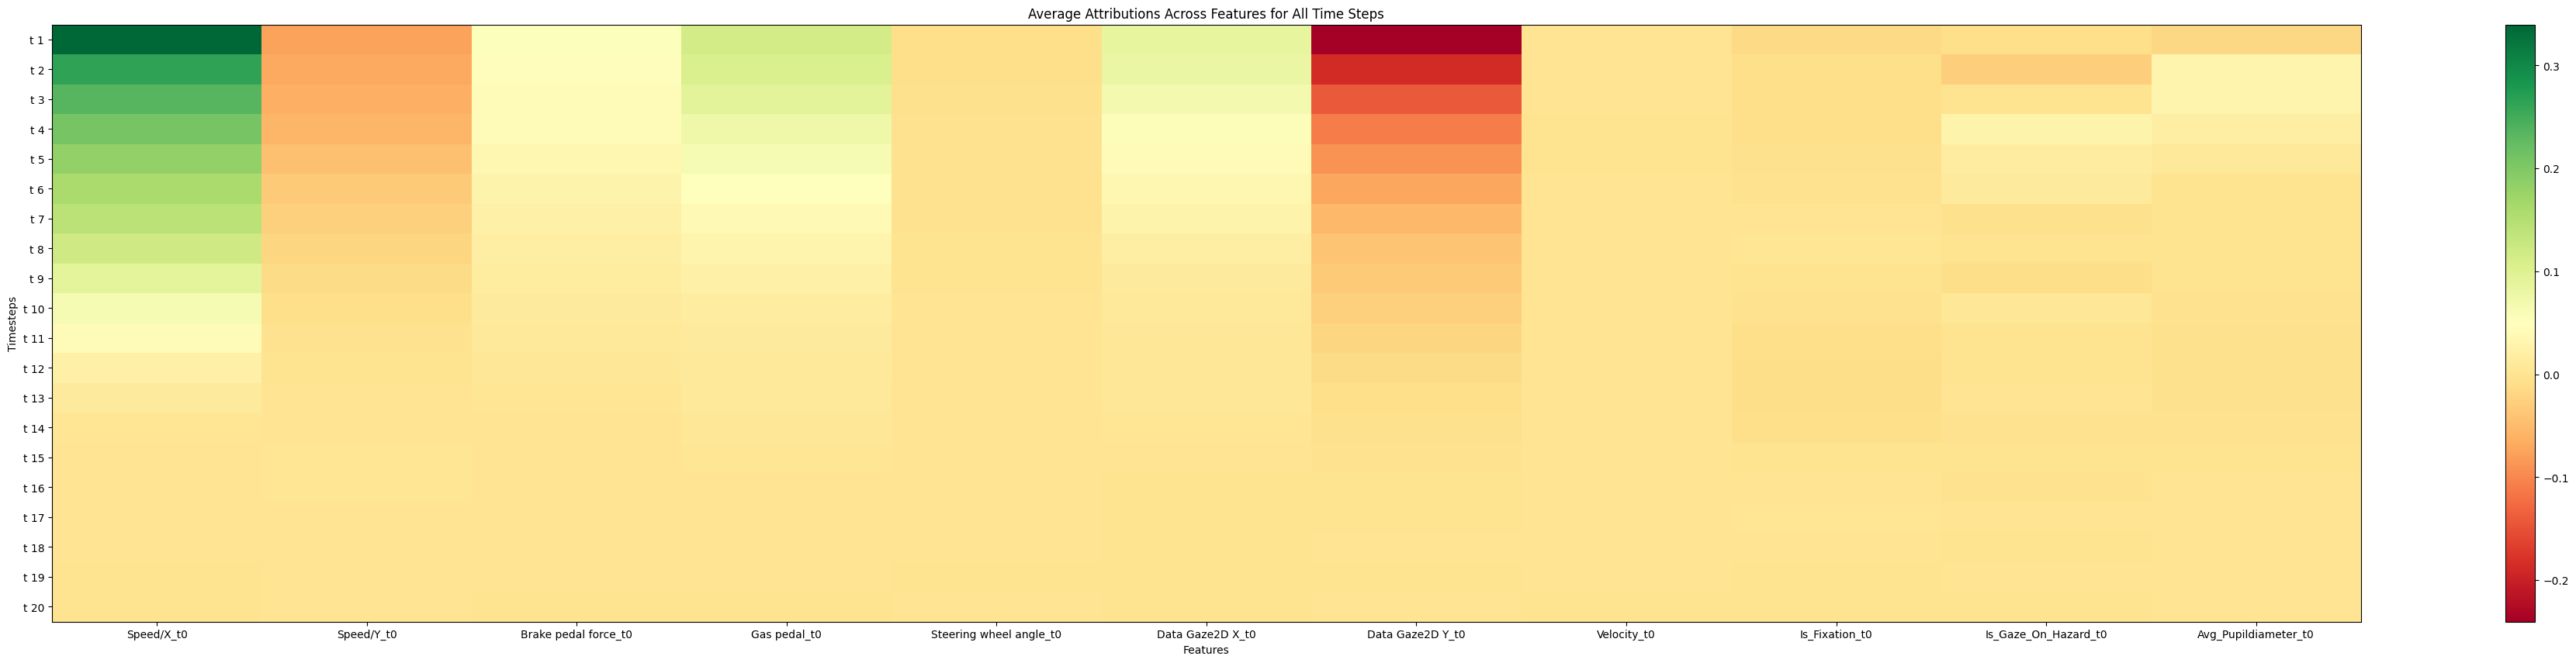

In [23]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

grid_result_model.train()

ig = IntegratedGradients(grid_result_model)

total_attributions = np.zeros_like(validation_windows_tensor[0].cpu().detach().numpy())

num_samples = 1000
for i in range(num_samples):
    input_tensor = validation_windows_tensor[i].unsqueeze(0).to(device)
    target_tensor = validation_targets_tensor[i].unsqueeze(0).to(device)

    attributions = ig.attribute(input_tensor, target_tensor)
    
    attributions = attributions.squeeze(0).cpu().detach().numpy()
    
    total_attributions += attributions

average_attributions = total_attributions / num_samples

plt.figure(figsize=(48,10))
plt.imshow(average_attributions, cmap='RdYlGn', aspect='auto')
plt.colorbar()
plt.title('Average Attributions Across Features for All Time Steps')
plt.xlabel('Features')
plt.ylabel('Timesteps')
plt.xticks(np.arange(11), labels=all_features)
plt.yticks(np.arange(20), labels=[f"t {i+1}" for i in range(20)])
plt.show()


In [160]:
print(model_history)

Log of LSTMClassifier forward pass:
	Random seed: 3011487889
	Time elapsed: 0.395s (0.388s spent logging)
	Structure:
		- recurrent (at most 3 loops)
		- with branching
		- no conditional (if-then) branching
		- 5 total modules
	Tensor info:
		- 13 total tensors (2.2 MB) computed in forward pass.
		- 13 tensors (2.2 MB) with saved activations.
	Parameters: 3 parameter operations (1344641 params total; 5.1 MB)
	Module Hierarchy:
		lstm
		fc1
		relu
		dropout
		fc2
	Layers (all have saved activations):
		  (0) input_1 
		  (1) zeros_1_1 
		  (2) zeros_2_2 
		  (3) lstm_1_3:1  (1/3 passes)
		  (4) lstm_1_3:2  (2/3 passes)
		  (5) lstm_1_3:3  (3/3 passes)
		  (6) getitem_1_4 
		  (7) linear_1_5 
		  (8) relu_1_6 
		  (9) dropout_1_7 
		  (10) linear_2_8 
		  (11) view_1_9 
		  (12) output_1 
